# 🐀 ANY RATS? - NYC Apartment Pest Risk Assessment

**Goal:** Analyze public NYC data to create a pest risk score for residential addresses

**Hypothesis:** Concentration of sanitary violations in restaurants correlates with rodent problems in nearby residential buildings

---

## 1. Setup & Data Loading

In [37]:
# Install required packages (run once)
# !pip install pandas numpy matplotlib seaborn sodapy folium geopandas

In [38]:
!pip install sodapy

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


### Load Dataset 1: Restaurant Inspections (rodent violations)

In [40]:
# NYC Open Data API endpoint
client = Socrata("data.cityofnewyork.us", None)

# Restaurant inspections - filtering for rodent violations (04L, 04K codes)
# 04L = "Evidence of mice or live mice present in facility's food and/or non-food areas"
# 04K = "Evidence of rats or live rats present in facility's food and/or non-food areas"

print("🔄 Loading restaurant inspection data...")

# Load recent data with rodent violations
results = client.get(
    "43nn-pn8j",  # Restaurant inspection dataset ID
    where="violation_code IN ('04K', '04L') AND inspection_date >= '2020-01-01'",
    limit=50000
)

restaurants_df = pd.DataFrame.from_records(results)

print(f"✅ Loaded {len(restaurants_df):,} restaurant violations")
print(f"Date range: {restaurants_df['inspection_date'].min()} to {restaurants_df['inspection_date'].max()}")
restaurants_df.head()

🔄 Loading restaurant inspection data...
✅ Loaded 18,455 restaurant violations
Date range: 2020-01-06T00:00:00.000 to 2026-01-27T00:00:00.000


,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,location
0,50109028,KENNEDY CHICKEN,Bronx,1915,WASHINGTON AVENUE,10457,3478620658,American,2024-11-14T00:00:00.000,Violations were cited in the following area(s).,04K,Evidence of rats or live rats in establishment...,Critical,10,A,2024-11-14T00:00:00.000,2026-01-29T06:00:12.000,Cycle Inspection / Re-inspection,40.84725786667,-73.897941700535,206,15,039500,2011246,2030340046,BX01,"{'type': 'Point', 'coordinates': [-73.89794170..."
1,50055022,BURRITO MARIACHI,Manhattan,189,CHURCH STREET,10007,2122275151,Tex-Mex,2024-12-12T00:00:00.000,Violations were cited in the following area(s).,04K,Evidence of rats or live rats in establishment...,Critical,13,A,2024-12-12T00:00:00.000,2026-01-29T06:00:12.000,Cycle Inspection / Initial Inspection,40.715812849346,-74.007221850438,101,01,003300,1001642,1001500015,MN24,"{'type': 'Point', 'coordinates': [-74.00722185..."
2,50126162,KATE'S CORNER CAFE,Queens,86-01,23 AVENUE,11369,5163516881,American,2023-05-10T00:00:00.000,Violations were cited in the following area(s).,04K,Evidence of rats or live rats in establishment...,Critical,10,NaN,NaN,2026-01-29T06:00:12.000,Pre-permit (Operational) / Initial Inspection,40.767168960925,-73.88361362053,403,22,034700,4437065,4010640002,QN28,"{'type': 'Point', 'coordinates': [-73.88361362..."
3,50126421,BLANK STREET,Brooklyn,75,LAFAYETTE AVENUE,11217,3477279842,Coffee/Tea,2025-08-11T00:00:00.000,Violations were cited in the following area(s).,04K,Evidence of rats or live rats in establishment...,Critical,19,NaN,NaN,2026-01-29T06:00:12.000,Cycle Inspection / Initial Inspection,40.687119320033,-73.975293334643,302,35,003300,3058852,3020990086,BK68,"{'type': 'Point', 'coordinates': [-73.97529333..."
4,50131642,JI BEI CHUAN,Brooklyn,5216,8 AVENUE,11220,7185873000,Chinese,2024-12-23T00:00:00.000,Violations were cited in the following area(s).,04K,Evidence of rats or live rats in establishment...,Critical,10,A,2024-12-23T00:00:00.000,2026-01-29T06:00:12.000,Cycle Inspection / Re-inspection,40.639845815087,-74.005037267022,307,43,010600,3014105,3008100046,BK34,"{'type': 'Point', 'coordinates': [-74.00503726..."


### Load Dataset 2: 311 Rat Sightings

In [41]:
print("🔄 Loading 311 rat sightings data...")

# Load recent rat sightings from 311 calls
rat_sightings = client.get(
    "3q43-55fe",  # Rat sightings dataset ID
    limit=50000
)

rat_sightings_df = pd.DataFrame.from_records(rat_sightings)

print(f"✅ Loaded {len(rat_sightings_df):,} rat sightings")
print(f"Date range: {rat_sightings_df['created_date'].min() if 'created_date' in rat_sightings_df else 'N/A'}")
rat_sightings_df.head()

🔄 Loading 311 rat sightings data...
✅ Loaded 50,000 rat sightings
Date range: 2023-10-13T07:37:29.000


,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,status,community_board,borough,x_coordinate_state_plane_,y_coordinate_state_plane_,park_facility_name,park_borough,latitude,longitude,location,closed_date,facility_type,resolution_action_updated_date
0,67670418,2026-01-29T00:14:49.000,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,1-2 Family Dwelling,11234,1242 EAST 70 STREET,EAST 70 STREET,AVENUE L,AVENUE M,AVENUE L,AVENUE M,ADDRESS,BROOKLYN,EAST 70 STREET,In Progress,18 BROOKLYN,BROOKLYN,1008066,167070,Unspecified,BROOKLYN,40.625213048408334,-73.9142049684431,"{'type': 'Point', 'coordinates': [-73.91420496...",NaN,NaN,NaN
1,67655099,2026-01-29T00:08:00.000,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10018,437 WEST 36 STREET,WEST 36 STREET,DYER AVENUE UNDERPASS 31 ST,10 AVENUE,DYER AVENUE UNDERPASS 31 ST,10 AVENUE,ADDRESS,NEW YORK,WEST 36 STREET,In Progress,04 MANHATTAN,MANHATTAN,985053,214492,Unspecified,MANHATTAN,40.755407465077404,-73.99710161017687,"{'type': 'Point', 'coordinates': [-73.99710161...",NaN,NaN,NaN
2,67657339,2026-01-28T22:47:41.000,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11385,363 ONDERDONK AVENUE,ONDERDONK AVENUE,DEKALB AVENUE,STOCKHOLM STREET,DEKALB AVENUE,STOCKHOLM STREET,ADDRESS,RIDGEWOOD,ONDERDONK AVENUE,In Progress,05 QUEENS,QUEENS,1007950,197345,Unspecified,QUEENS,40.70831145371358,-73.91451641653214,"{'type': 'Point', 'coordinates': [-73.91451641...",NaN,NaN,NaN
3,67666067,2026-01-28T22:01:27.000,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,1-2 Family Mixed Use Building,11435,88-02 139 STREET,139 STREET,88 AVENUE,88 ROAD,88 AVENUE,88 ROAD,ADDRESS,JAMAICA,139 STREET,In Progress,12 QUEENS,QUEENS,1035851,195662,Unspecified,QUEENS,40.7035733017971,-73.81389335468357,"{'type': 'Point', 'coordinates': [-73.81389335...",NaN,NaN,NaN
4,67659511,2026-01-28T19:39:34.000,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Sidewalk,10128,43 EAST 89 STREET,EAST 89 STREET,MADISON AVENUE,PARK AVENUE,MADISON AVENUE,PARK AVENUE,ADDRESS,NEW YORK,EAST 89 STREET,In Progress,08 MANHATTAN,MANHATTAN,996402,224278,Unspecified,MANHATTAN,40.78225917409251,-73.95612025119571,"{'type': 'Point', 'coordinates': [-73.95612025...",NaN,NaN,NaN


### Load Dataset 3: Rodent Inspections (Official)

In [42]:
print("🔄 Loading official rodent inspection data...")

# Load rodent inspection results
rodent_inspections = client.get(
    "p937-wjvj",  # Rodent inspection dataset ID
    limit=50000
)

rodent_inspections_df = pd.DataFrame.from_records(rodent_inspections)

print(f"✅ Loaded {len(rodent_inspections_df):,} rodent inspections")
rodent_inspections_df.head()

🔄 Loading official rodent inspection data...
✅ Loaded 50,000 rodent inspections


,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,boro_code,block,lot,house_number,street_name,zip_code,x_coord,y_coord,latitude,longitude,borough,inspection_date,result,approved_date,location,community_board,council_district,census_tract,bin,nta,:@computed_region_92fq_4b7q,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_efsh_h5xi,:@computed_region_sbqj_enih
0,Initial,11670593,PC6530234,1,2032890025,2,03289,0025,326,EAST 198 STREET,10458,1015316,255377,40.867726534028,-73.887461100839,Bronx,2010-08-30T15:23:11.000,Passed,2010-09-03T10:43:36.000,"{'latitude': '40.867726534028', 'longitude': '...",7,15,40502,2016678,Bedford Park,22,24,5,10936,34
1,Initial,11758853,PC6101553,1,1013290121,1,01329,0121,245,EAST 55 STREET,10022,993525,215573,40.758511490599,-73.967433834067,Manhattan,2011-08-18T12:05:54.000,Passed,2011-08-19T12:02:56.000,"{'latitude': '40.758511490599', 'longitude': '...",6,4,10801,1038588,East Midtown-Turtle Bay,51,71,4,12419,9
2,Initial,12504178,PC7270050,1,NaN,3,03141,0020,NaN,MONTIETH STREET,11206,1002160,194840,40.7014506131434,-73.9354065814951,Brooklyn,2018-10-10T12:57:02.000,Passed,2018-10-11T08:59:21.000,"{'latitude': '40.7014506131434', 'longitude': ...",NaN,NaN,NaN,NaN,NaN,30,42,2,17213,53
3,Initial,12560587,PC6481130,1,1021110015,1,02111,0015,470,WEST 165 STREET,10032,1001506,244337,40.83764407994,-73.93777140242,Manhattan,2019-02-07T12:48:34.000,Passed,2019-02-13T10:28:33.000,"{'latitude': '40.83764407994', 'longitude': '-...",12,10,24301,1062635,Washington Heights (South),39,47,4,13090,21
4,Initial,12628612,PC7229376,1,3033350026,3,03335,0026,308,LINDEN STREET,11237,1008035,193720,40.698368377396,-73.914503763762,Brooklyn,2019-06-20T16:02:23.000,Passed,2019-06-26T13:35:17.000,"{'latitude': '40.698368377396', 'longitude': '...",4,37,433,3076324,Bushwick (East),37,42,2,13828,53


---
## 2. Quick Data Exploration

In [43]:
# Dataset shapes
print("\n📊 Dataset Summary:")
print(f"Restaurant violations: {restaurants_df.shape}")
print(f"311 Rat sightings: {rat_sightings_df.shape}")
print(f"Official inspections: {rodent_inspections_df.shape}")

# Check columns
print("\n🔍 Available columns in Restaurant data:")
print(restaurants_df.columns.tolist())


📊 Dataset Summary:
Restaurant violations: (18455, 27)
311 Rat sightings: (50000, 30)
Official inspections: (50000, 30)

🔍 Available columns in Restaurant data:
['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone', 'cuisine_description', 'inspection_date', 'action', 'violation_code', 'violation_description', 'critical_flag', 'score', 'grade', 'grade_date', 'record_date', 'inspection_type', 'latitude', 'longitude', 'community_board', 'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'location']


In [44]:
# Check for geolocation data
print("\n📍 Geolocation check:")
print("Restaurants with coordinates:", restaurants_df[['latitude', 'longitude']].notna().all(axis=1).sum())
print("Rat sightings with coordinates:",
      rat_sightings_df[['latitude', 'longitude']].notna().all(axis=1).sum() if 'latitude' in rat_sightings_df else 'N/A')


📍 Geolocation check:
Restaurants with coordinates: 18421
Rat sightings with coordinates: 49714


🐀 TOP BOROUGHS BY RAT VIOLATIONS

boro
Manhattan        6371
Brooklyn         5136
Queens           4346
Bronx            1997
Staten Island     604
0                   1
Name: count, dtype: int64


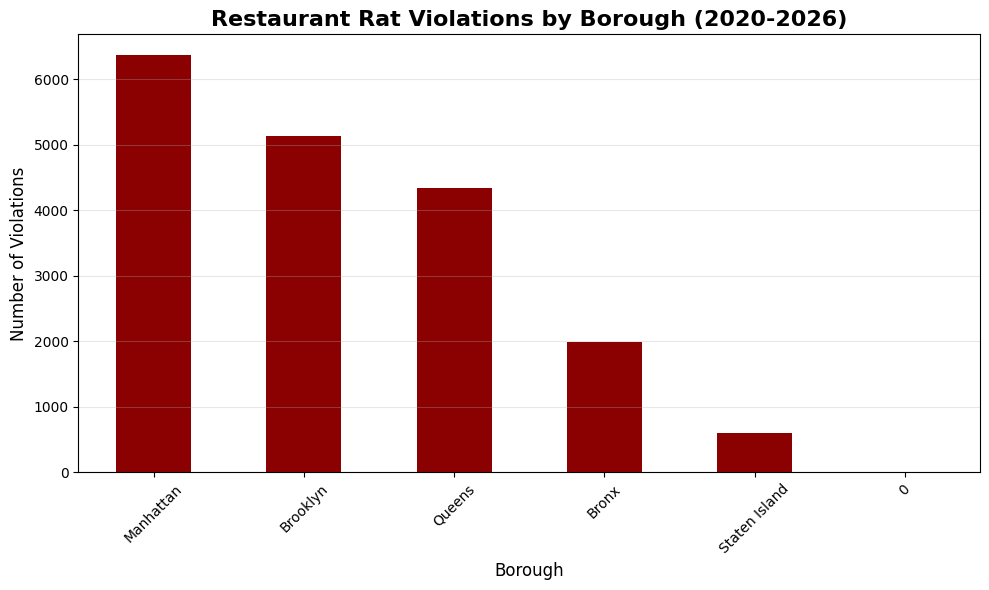


📊 Total violations analyzed: 18,455


In [54]:
# === ANALYSIS 1: Top Boroughs ===
print("🐀 TOP BOROUGHS BY RAT VIOLATIONS\n")

borough_counts = restaurants_df['boro'].value_counts()
print(borough_counts)

# Визуализация
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
borough_counts.plot(kind='bar', color='#8B0000')
plt.title('Restaurant Rat Violations by Borough (2020-2026)', fontsize=16, fontweight='bold')
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Number of Violations', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Total violations analyzed: {len(restaurants_df):,}")

🐀 RAT VIOLATIONS PER CAPITA ANALYSIS

      Borough  Violations Density (ppl/sq mi)  Violations per 1K residents
       Queens        4346              21,000                       206.95
     Brooklyn        5136              37,000                       138.81
    Manhattan        6371              70,000                        91.01
Staten Island         604               8,000                        75.50
        Bronx        1997              34,000                        58.74



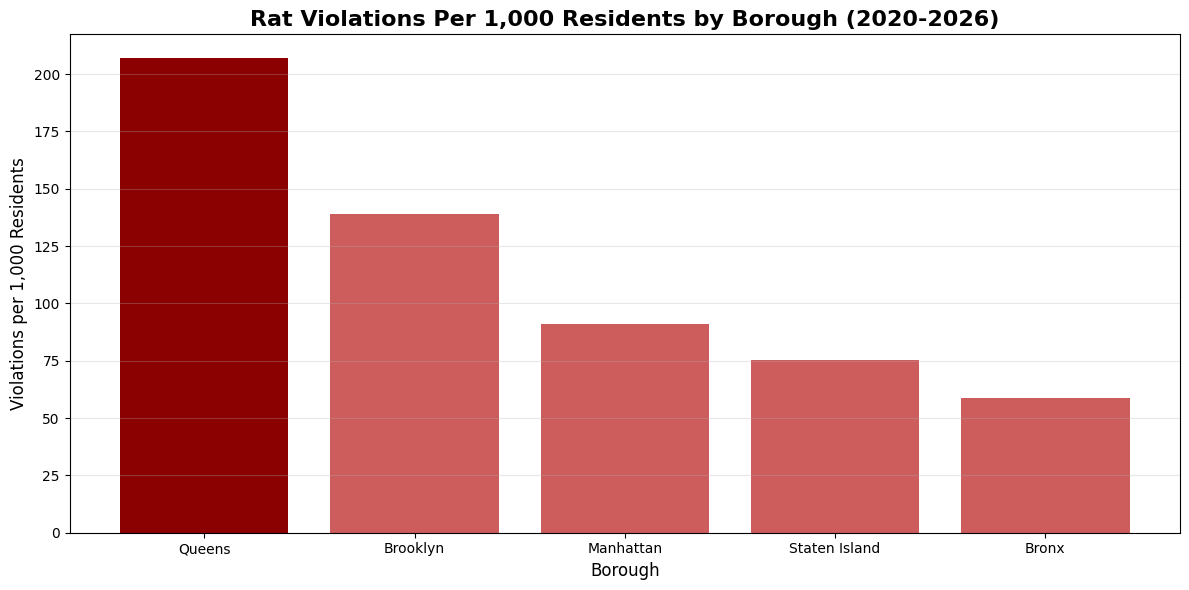


🎯 WORST (per capita): Queens
   206.95 violations per 1,000 residents

💡 KEY INSIGHT: Despite lower population density, Queens
   has the highest rat problem per capita — suggesting infrastructure/sanitation issues.


In [46]:
# === ANALYSIS: Violations PER CAPITA by Borough ===
print("🐀 RAT VIOLATIONS PER CAPITA ANALYSIS\n")

# Population density data (people per sq mile, approximate)
population_density = {
    'Manhattan': 70000,
    'Brooklyn': 37000,
    'Queens': 21000,
    'Bronx': 34000,
    'Staten Island': 8000
}

# Get violation counts
borough_counts = restaurants_df['boro'].value_counts()

# Calculate violations per 1000 residents (normalized)
results = []
for borough, violations in borough_counts.items():
    if borough in population_density and borough != '0':
        density = population_density[borough]
        per_capita = (violations / density) * 1000  # per 1000 residents
        results.append({
            'Borough': borough,
            'Violations': violations,
            'Density (ppl/sq mi)': f"{density:,}",
            'Violations per 1K residents': round(per_capita, 2)
        })

# Create DataFrame and sort by per capita
df_per_capita = pd.DataFrame(results)
df_per_capita = df_per_capita.sort_values('Violations per 1K residents', ascending=False)

print(df_per_capita.to_string(index=False))
print("\n" + "="*70)

# Visualization
plt.figure(figsize=(12, 6))
colors = ['#8B0000' if x == df_per_capita.iloc[0]['Borough'] else '#CD5C5C'
          for x in df_per_capita['Borough']]

plt.bar(df_per_capita['Borough'],
        df_per_capita['Violations per 1K residents'],
        color=colors)
plt.title('Rat Violations Per 1,000 Residents by Borough (2020-2026)',
         fontsize=16, fontweight='bold')
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Violations per 1,000 Residents', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 WORST (per capita): {df_per_capita.iloc[0]['Borough']}")
print(f"   {df_per_capita.iloc[0]['Violations per 1K residents']} violations per 1,000 residents")
print(f"\n💡 KEY INSIGHT: Despite lower population density, {df_per_capita.iloc[0]['Borough']}")
print(f"   has the highest rat problem per capita — suggesting infrastructure/sanitation issues.")

🐀 TOP 20 ZIP CODES WITH MOST RAT VIOLATIONS (2020-2026)

ZIP Code   Borough  Violations
   10003 Manhattan         394
   10013 Manhattan         385
   11220  Brooklyn         364
   10002 Manhattan         361
   10016 Manhattan         344
   10019 Manhattan         323
   10012 Manhattan         321
   10014 Manhattan         306
   11215  Brooklyn         293
   10011 Manhattan         283
   10036 Manhattan         276
   11354    Queens         265
   11385    Queens         246
   10022 Manhattan         245
   11211  Brooklyn         241
   11372    Queens         240
   10009 Manhattan         238
   10001 Manhattan         236
   11355    Queens         222
   11201  Brooklyn         219


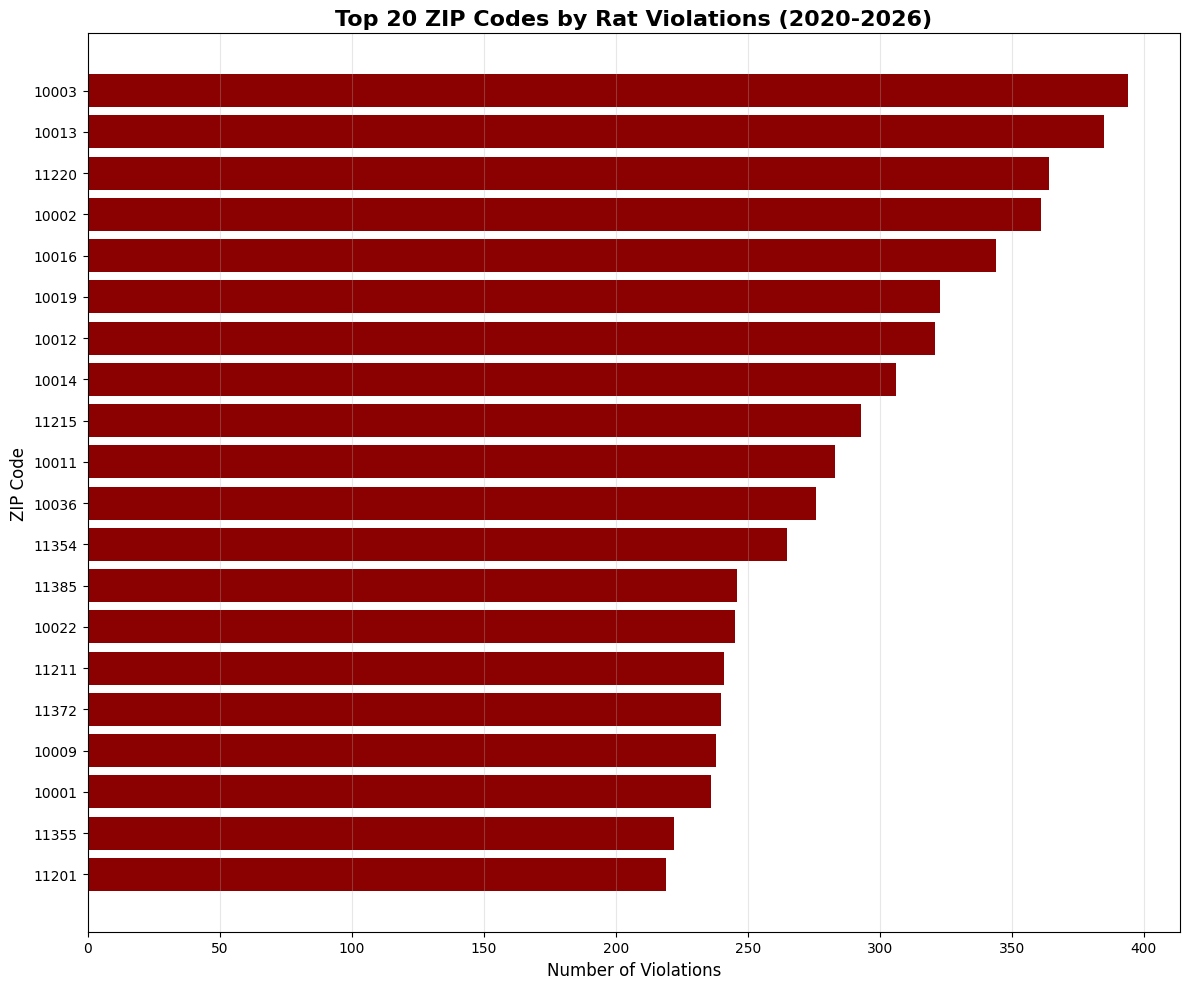


🎯 Check these ZIP codes before renting.
📊 Total violations analyzed: 18,455


In [47]:
# === ANALYSIS: Top 20 Worst ZIP Codes ===
print("🐀 TOP 20 ZIP CODES WITH MOST RAT VIOLATIONS (2020-2026)\n")

# Count violations by zip code
zip_counts = restaurants_df['zipcode'].value_counts().head(20)

# Create a cleaner display
zip_data = []
for zipcode, count in zip_counts.items():
    # Get borough for this zip
    borough = restaurants_df[restaurants_df['zipcode'] == zipcode]['boro'].mode()
    borough_name = borough.values[0] if len(borough) > 0 else 'Unknown'

    zip_data.append({
        'ZIP Code': zipcode,
        'Borough': borough_name,
        'Violations': count
    })

zip_df = pd.DataFrame(zip_data)
print(zip_df.to_string(index=False))

# Visualization - horizontal bar for better readability
plt.figure(figsize=(12, 10))
plt.barh(range(len(zip_counts)), zip_counts.values, color='#8B0000')
plt.yticks(range(len(zip_counts)), zip_counts.index)
plt.xlabel('Number of Violations', fontsize=12)
plt.ylabel('ZIP Code', fontsize=12)
plt.title('Top 20 ZIP Codes by Rat Violations (2020-2026)', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()  # Highest on top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 Check these ZIP codes before renting.")
print(f"📊 Total violations analyzed: {len(restaurants_df):,}")

In [48]:
# Show all column names
print("📋 ALL COLUMNS in restaurant data:\n")
print(restaurants_df.columns.tolist())
print("\n" + "="*70 + "\n")

# Show sample of potentially useful geographic columns
geo_cols = [col for col in restaurants_df.columns
            if any(x in col.lower() for x in ['nta', 'bbl', 'bin', 'district', 'community', 'council'])]

if geo_cols:
    print(f"🎯 Found these geographic columns: {geo_cols}\n")
    print(restaurants_df[geo_cols].head(10))
else:
    print("Let me show a sample of all data to find geographic identifiers:")
    print(restaurants_df.head())

📋 ALL COLUMNS in restaurant data:

['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone', 'cuisine_description', 'inspection_date', 'action', 'violation_code', 'violation_description', 'critical_flag', 'score', 'grade', 'grade_date', 'record_date', 'inspection_type', 'latitude', 'longitude', 'community_board', 'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'location']


🎯 Found these geographic columns: ['community_board', 'council_district', 'bin', 'bbl', 'nta']

  community_board council_district      bin         bbl   nta
0             206               15  2011246  2030340046  BX01
1             101               01  1001642  1001500015  MN24
2             403               22  4437065  4010640002  QN28
3             302               35  3058852  3020990086  BK68
4             307               43  3014105  3008100046  BK34
5             402               26  4028418  4012340183  QN63
6             308               35  3032221  3012540011  BK61
7            

🐀 TOP 20 NEIGHBORHOODS (NTA) WITH MOST RAT VIOLATIONS

NTA Code   Borough  Violations
    MN23 Manhattan         598
    MN17 Manhattan         594
    MN13 Manhattan         463
    MN27 Manhattan         448
    MN22 Manhattan         440
    MN24 Manhattan         415
    MN15 Manhattan         374
    BK37  Brooklyn         343
    MN19 Manhattan         335
    QN22    Queens         304
    MN12 Manhattan         301
    BK34  Brooklyn         295
    QN70    Queens         295
    BK31  Brooklyn         259
    BK73  Brooklyn         258
    MN20 Manhattan         243
    QN31    Queens         234
    MN40 Manhattan         233
    QN28    Queens         221
    BK28  Brooklyn         216


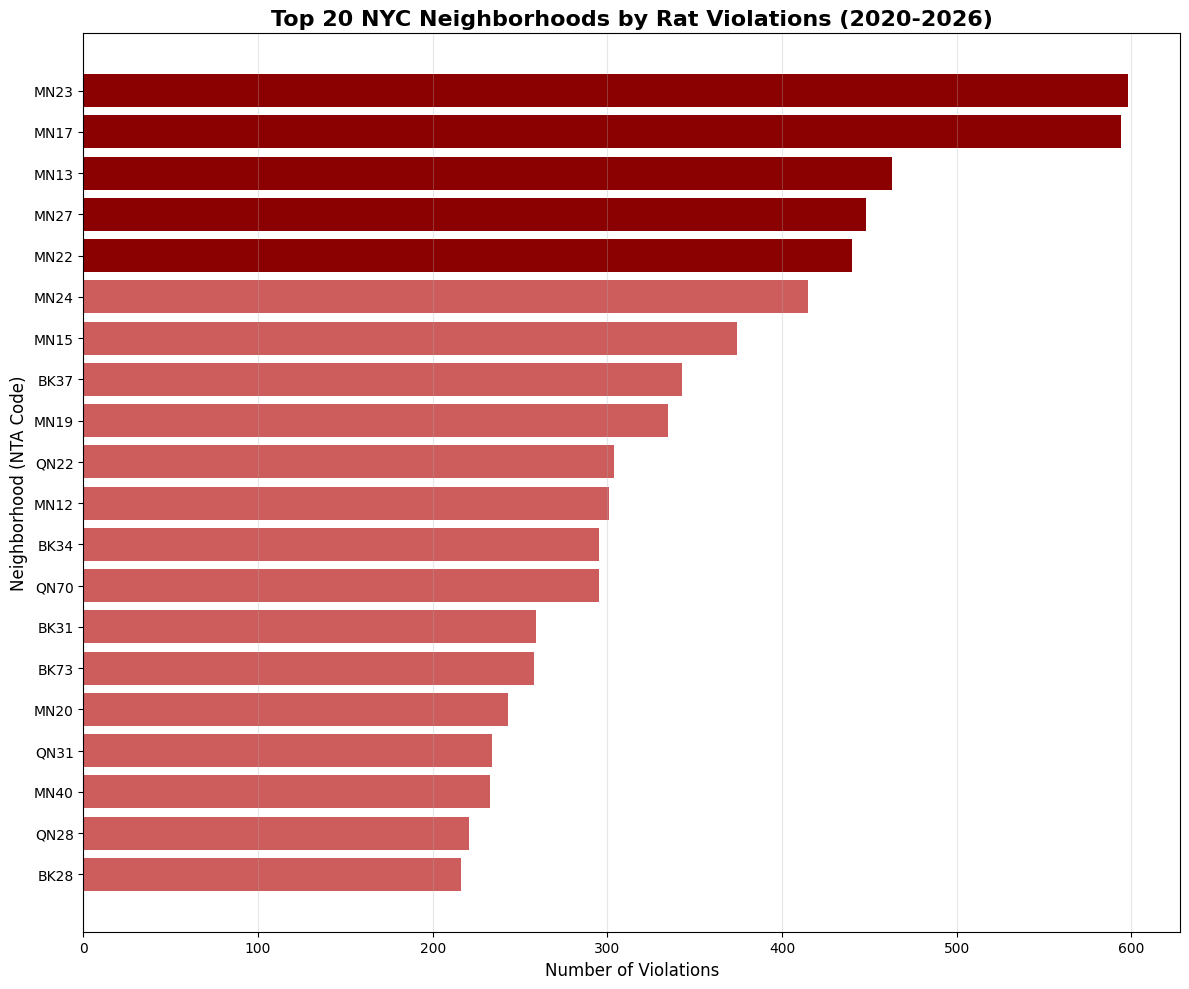


🎯 Worst neighborhood: MN23 (Manhattan)
   598 violations

💡 NTA codes are more precise than ZIP codes — better for apartment hunting.


In [49]:
# === ANALYSIS: Top 20 Worst Neighborhoods (NTA) ===
print("🐀 TOP 20 NEIGHBORHOODS (NTA) WITH MOST RAT VIOLATIONS\n")

# Count violations by NTA
nta_counts = restaurants_df['nta'].value_counts().head(20)

# Create detailed table with borough info
nta_data = []
for nta_code, count in nta_counts.items():
    # Get borough
    borough = restaurants_df[restaurants_df['nta'] == nta_code]['boro'].mode()
    borough_name = borough.values[0] if len(borough) > 0 else 'Unknown'

    nta_data.append({
        'NTA Code': nta_code,
        'Borough': borough_name,
        'Violations': count
    })

nta_df = pd.DataFrame(nta_data)
print(nta_df.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 10))
colors = ['#8B0000' if i < 5 else '#CD5C5C' for i in range(len(nta_counts))]
plt.barh(range(len(nta_counts)), nta_counts.values, color=colors)
plt.yticks(range(len(nta_counts)), nta_counts.index)
plt.xlabel('Number of Violations', fontsize=12)
plt.ylabel('Neighborhood (NTA Code)', fontsize=12)
plt.title('Top 20 NYC Neighborhoods by Rat Violations (2020-2026)',
         fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 Worst neighborhood: {nta_counts.index[0]} ({nta_df.iloc[0]['Borough']})")
print(f"   {nta_counts.values[0]} violations")
print(f"\n💡 NTA codes are more precise than ZIP codes — better for apartment hunting.")

In [50]:
# Let's check if there's a neighborhood NAME field
print("Looking for neighborhood names...")
name_cols = [col for col in restaurants_df.columns if 'name' in col.lower() or 'neighborhood' in col.lower()]
print(f"Found columns: {name_cols}\n")

# Show sample
if name_cols:
    print(restaurants_df[['nta'] + name_cols].drop_duplicates('nta').head(20))

Looking for neighborhood names...
Found columns: []



In [51]:
# === Load NTA Names Lookup (direct CSV) ===
print("📍 Loading NTA neighborhood names...\n")

# Try direct CSV download from NYC Planning
try:
    # 2010 NTA dataset with names
    url = "https://data.cityofnewyork.us/resource/cpf4-rkhq.csv?$limit=300"
    nta_names_df = pd.read_csv(url)

    print(f"✅ Loaded {len(nta_names_df)} NTA records")
    print(f"Columns: {nta_names_df.columns.tolist()}\n")

    # Show sample
    if 'ntacode' in nta_names_df.columns and 'ntaname' in nta_names_df.columns:
        print("Sample NTA names:")
        print(nta_names_df[['ntacode', 'ntaname']].head(10))
    else:
        print("Sample data:")
        print(nta_names_df.head())

except Exception as e:
    print(f"❌ Error loading NTA names: {e}")
    print("\nTrying alternative source...")

    # Alternative: Try 2020 NTAs
    try:
        url2 = "https://data.cityofnewyork.us/resource/9nt8-h7nd.csv?$limit=300"
        nta_names_df = pd.read_csv(url2)
        print(f"✅ Loaded {len(nta_names_df)} NTA records from 2020 dataset")
        print(f"Columns: {nta_names_df.columns.tolist()}")
        print(nta_names_df.head())
    except Exception as e2:
        print(f"❌ Also failed: {e2}")
        print("\nWe can manually add names for Top 20 instead.")

📍 Loading NTA neighborhood names...

❌ Error loading NTA names: HTTP Error 404: Not Found

Trying alternative source...
✅ Loaded 262 NTA records from 2020 dataset
Columns: ['borocode', 'boroname', 'countyfips', 'nta2020', 'ntaname', 'ntaabbrev', 'ntatype', 'cdta2020', 'cdtaname', 'shape_leng', 'shape_area', 'the_geom']
   borocode  boroname  countyfips nta2020             ntaname  ntaabbrev  \
0         3  Brooklyn          47  BK0101          Greenpoint      Grnpt   
1         3  Brooklyn          47  BK0102        Williamsburg   Wllmsbrg   
2         3  Brooklyn          47  BK0103  South Williamsburg  SWllmsbrg   
3         3  Brooklyn          47  BK0104   East Williamsburg  EWllmsbrg   
4         3  Brooklyn          47  BK0201    Brooklyn Heights      BkHts   

   ntatype cdta2020                                           cdtaname  \
0        0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   
1        0     BK01     BK01 Williamsburg-Greenpoint (CD 1 Equivalent)   


📍 Adding neighborhood names to Top 20 NTAs

NTA Code                                     Neighborhood   Borough  Violations
    MN23                                     West Village Manhattan         598
    MN17                            Midtown-Midtown South Manhattan         594
    MN13       Hudson Yards-Chelsea-Flatiron-Union Square Manhattan         463
    MN27                                        Chinatown Manhattan         448
    MN22                                         Gramercy Manhattan         440
    MN24           SoHo-TriBeCa-Civic Center-Little Italy Manhattan         415
    MN15                                  Lower East Side Manhattan         374
    BK37                               Park Slope-Gowanus  Brooklyn         343
    MN19                          Turtle Bay-East Midtown Manhattan         335
    QN22                                          Astoria    Queens         304
    MN12                                  Upper West Side Manhattan         

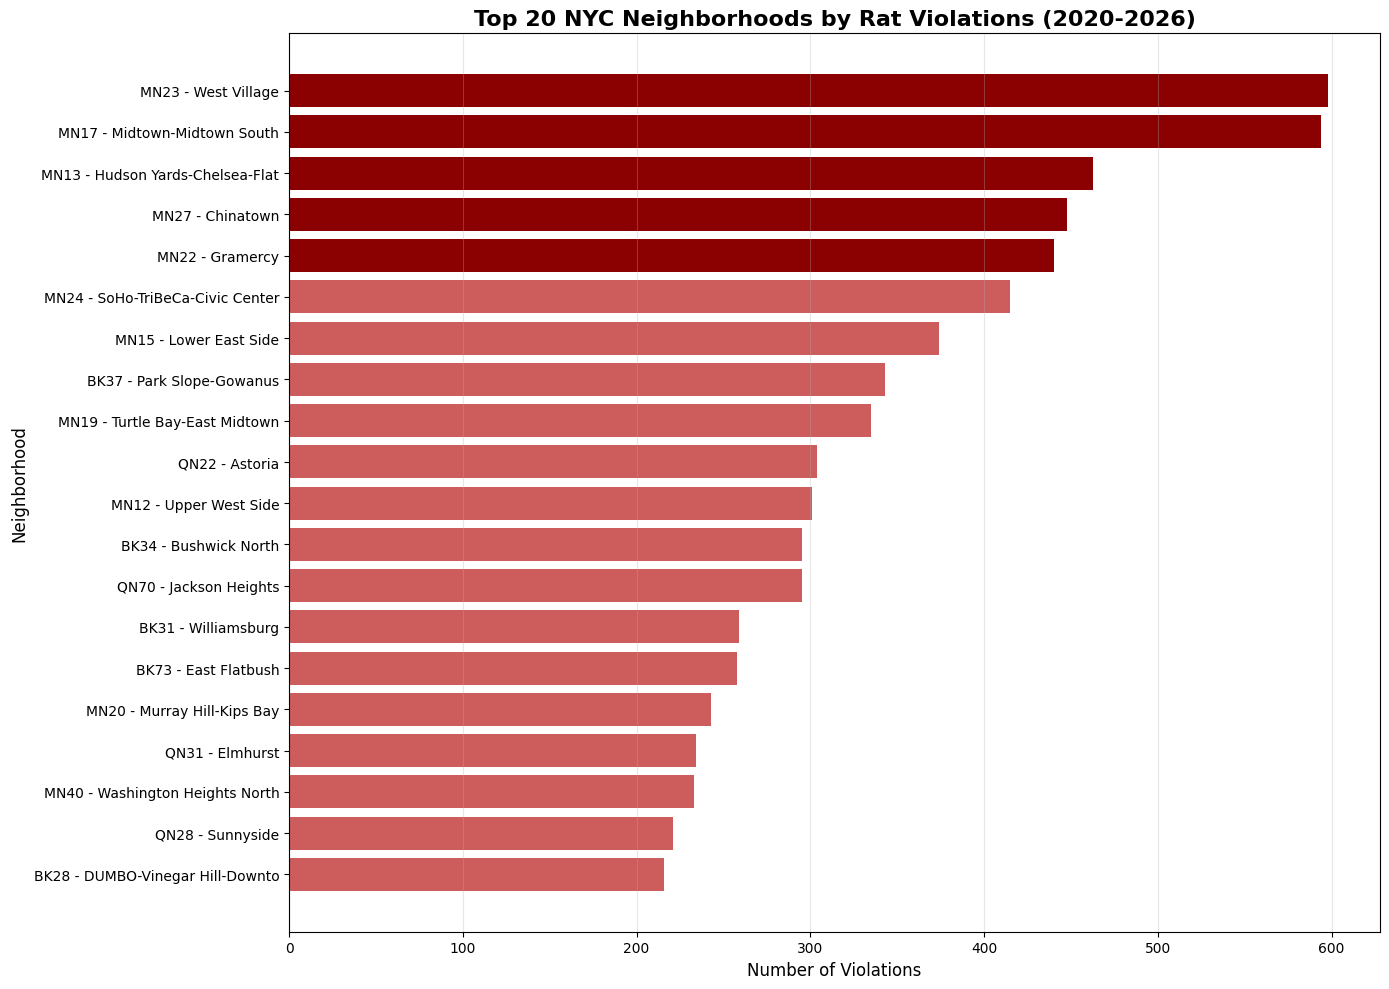


🎯 Worst neighborhood: West Village (MN23)
   598 violations


In [52]:
# === Manual NTA Name Mapping (Top 20) ===
print("📍 Adding neighborhood names to Top 20 NTAs\n")

# Manual mapping from NYC Planning documentation
nta_names_manual = {
    'MN23': 'West Village',
    'MN17': 'Midtown-Midtown South',
    'MN13': 'Hudson Yards-Chelsea-Flatiron-Union Square',
    'MN27': 'Chinatown',
    'MN22': 'Gramercy',
    'MN24': 'SoHo-TriBeCa-Civic Center-Little Italy',
    'MN15': 'Lower East Side',
    'BK37': 'Park Slope-Gowanus',
    'MN19': 'Turtle Bay-East Midtown',
    'QN22': 'Astoria',
    'MN12': 'Upper West Side',
    'BK34': 'Bushwick North',
    'QN70': 'Jackson Heights',
    'BK31': 'Williamsburg',
    'BK73': 'East Flatbush',
    'MN20': 'Murray Hill-Kips Bay',
    'QN31': 'Elmhurst',
    'MN40': 'Washington Heights North',
    'QN28': 'Sunnyside',
    'BK28': 'DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill'
}

# Get top 20 NTAs
nta_counts = restaurants_df['nta'].value_counts().head(20)

# Create enhanced table
nta_data_named = []
for nta_code, count in nta_counts.items():
    borough = restaurants_df[restaurants_df['nta'] == nta_code]['boro'].mode()
    borough_name = borough.values[0] if len(borough) > 0 else 'Unknown'

    # Get neighborhood name
    neighborhood = nta_names_manual.get(nta_code, 'Unknown')

    nta_data_named.append({
        'NTA Code': nta_code,
        'Neighborhood': neighborhood,
        'Borough': borough_name,
        'Violations': count
    })

nta_df_named = pd.DataFrame(nta_data_named)
print(nta_df_named.to_string(index=False))

# Visualization with names
plt.figure(figsize=(14, 10))
labels = [f"{row['NTA Code']} - {row['Neighborhood'][:25]}" for _, row in nta_df_named.iterrows()]
colors = ['#8B0000' if i < 5 else '#CD5C5C' for i in range(len(nta_df_named))]

plt.barh(range(len(nta_df_named)), nta_df_named['Violations'], color=colors)
plt.yticks(range(len(nta_df_named)), labels, fontsize=10)
plt.xlabel('Number of Violations', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.title('Top 20 NYC Neighborhoods by Rat Violations (2020-2026)',
         fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 Worst neighborhood: {nta_df_named.iloc[0]['Neighborhood']} ({nta_df_named.iloc[0]['NTA Code']})")
print(f"   {nta_df_named.iloc[0]['Violations']} violations")

---
## 3. Next Steps (Your Analysis Here)

**Phase 1 - Basic Analysis:**
- [ ] Clean data (handle missing values, dates)
- [ ] Analyze by borough/zip code
- [ ] Count violations per area
- [ ] Create heat map visualization

**Phase 2 - Risk Scoring:**
- [ ] Combine datasets by location
- [ ] Calculate density of violations within radius (100m, 200m)
- [ ] Create risk score (0-100)
- [ ] Test on sample addresses

**Phase 3 - Visualization:**
- [ ] Interactive map (Folium)
- [ ] Time series (seasonal patterns)
- [ ] Top 10 riskiest neighborhoods

**Phase 4 - Product Mockup:**
- [ ] Simple Streamlit app
- [ ] Input: address → Output: risk score + nearby violations


In [55]:
# === Save All Graphs as PNG ===
print("📥 Saving all visualizations...\n")

# Re-generate and save each graph

# Graph 1: Borough totals
plt.figure(figsize=(10, 6))
borough_counts = restaurants_df['boro'].value_counts()
borough_counts.plot(kind='bar', color='#8B0000')
plt.title('Restaurant Rat Violations by Borough (2020-2026)', fontsize=16, fontweight='bold')
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Number of Violations', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('borough_totals.png', dpi=300, bbox_inches='tight')
print("✅ Saved: borough_totals.png")
plt.close()

# Graph 2: Per capita
population_density = {
    'Manhattan': 70000, 'Brooklyn': 37000, 'Queens': 21000,
    'Bronx': 34000, 'Staten Island': 8000
}
results = []
for borough, violations in borough_counts.items():
    if borough in population_density and borough != '0':
        per_capita = (violations / population_density[borough]) * 1000
        results.append({'Borough': borough, 'Violations per 1K': round(per_capita, 2)})

df_pc = pd.DataFrame(results).sort_values('Violations per 1K', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(df_pc['Borough'], df_pc['Violations per 1K'], color='#8B0000')
plt.title('Rat Violations Per 1,000 Residents by Borough (2020-2026)', fontsize=16, fontweight='bold')
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Violations per 1,000 Residents', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('per_capita.png', dpi=300, bbox_inches='tight')
print("✅ Saved: per_capita.png")
plt.close()

# Graph 3: Top 20 Neighborhoods
nta_names_manual = {
    'MN23': 'West Village', 'MN17': 'Midtown-Midtown South',
    'MN13': 'Hudson Yards-Chelsea-Flatiron', 'MN27': 'Chinatown',
    'MN22': 'Gramercy', 'MN24': 'SoHo-TriBeCa-Civic Center',
    'MN15': 'Lower East Side', 'BK37': 'Park Slope-Gowanus',
    'MN19': 'Turtle Bay-East Midtown', 'QN22': 'Astoria',
    'MN12': 'Upper West Side', 'BK34': 'Bushwick North',
    'QN70': 'Jackson Heights', 'BK31': 'Williamsburg',
    'BK73': 'East Flatbush', 'MN20': 'Murray Hill-Kips Bay',
    'QN31': 'Elmhurst', 'MN40': 'Washington Heights North',
    'QN28': 'Sunnyside', 'BK28': 'DUMBO-Downtown Brooklyn'
}

nta_counts = restaurants_df['nta'].value_counts().head(20)
labels = [f"{code} - {nta_names_manual.get(code, 'Unknown')[:25]}" for code in nta_counts.index]

plt.figure(figsize=(14, 10))
plt.barh(range(len(nta_counts)), nta_counts.values, color='#8B0000')
plt.yticks(range(len(nta_counts)), labels, fontsize=10)
plt.xlabel('Number of Violations', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.title('Top 20 NYC Neighborhoods by Rat Violations (2020-2026)', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top20_neighborhoods.png', dpi=300, bbox_inches='tight')
print("✅ Saved: top20_neighborhoods.png")
plt.close()

print("\n✅ All graphs saved! Check the Files tab (📁) on the left.")

📥 Saving all visualizations...

✅ Saved: borough_totals.png
✅ Saved: per_capita.png
✅ Saved: top20_neighborhoods.png

✅ All graphs saved! Check the Files tab (📁) on the left.


---
## Save processed data for later use

In [53]:
# Uncomment to save
# restaurants_df.to_csv('data/restaurants_rodent_violations.csv', index=False)
# rat_sightings_df.to_csv('data/311_rat_sightings.csv', index=False)
# rodent_inspections_df.to_csv('data/official_rodent_inspections.csv', index=False)
# print("💾 Data saved!")